In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotmap import DotMap
import torch
import torch.nn as nn
import torch.autograd as autograd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
torch.cuda.is_available()

True

# PICK UP WHERE YOU LEFT OFF
### Loss was converging well but RFR was beating by mile on sample of overfitted train set of 1000.
### Now implementing train and test sets. Last train loop left to change.
### Then will compare performance

In [5]:
data = pd.read_parquet("../data_manipulation/final_night_data.parquet")

In [6]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [7]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [8]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [9]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [10]:
data.shape

(21639, 74)

In [11]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [12]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

In [13]:
train_data, test_data = split_data(data)

In [14]:
X_train = train_data[drivers]
NEE_train = train_data["NEE"]
dT_train = train_data["dTa"]
dNEE_train = train_data["dNEE"]
K_train = train_data[["E0", "rb"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE"]
dT_test = test_data["dTa"]
dNEE_test = test_data["dNEE"]
K_test = test_data[["E0", "rb"]]


In [15]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [16]:
class PIVAE_SDE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(PIVAE_SDE, self).__init__()

        self.Tref = torch.tensor(10).to("cuda")
        self.T0 = torch.tensor(46.02).to("cuda")
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Decoder network for NEE (u)
        self.nee_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # Output NEE (u)
        )
        
        # Decoder network for dT/dt (f)
        self.temp_derivative_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # Output dT/dt
        )
        
        # Decoder network for E0 and rb (k)
        self.k_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)  # Output E0 and rb
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, f, k):
        input_ = torch.cat((x, f.view(x.shape[0], 1), k), dim=1).to("cuda")
        z = self.encoder(input_)
        nee = self.nee_decoder(z)
        dT_dt = self.temp_derivative_decoder(z)
        k = self.k_decoder(z)
        f, residual = self.physics_residual(nee, x, k, x[:, 0].view((-1, 1)), dT_dt)
        
        return nee, dT_dt, k, f, z, residual

    def physics_residual(self, nee, x, k, T, dT_dt):
        E0 = k[:, 0].view((-1, 1))
        rb = k[:, 1].view((-1, 1))
        
        # Compute dNEE/dT using predicted E0 and rb
        exp_term = torch.exp(E0 * (1.0 / (self.Tref - self.T0) - 1.0 / (T - self.T0))).view((-1, 1))
        dNEE_dT = rb * (E0 / (T - self.T0)**2) * exp_term

        # Physics-based residual f = dNEE/dt - (dNEE/dT) * (dT/dt)
        #f_residual = autograd.grad(nee, x, grad_outputs=torch.ones_like(nee), create_graph=True)[:, 0]
        residual = torch.zeros_like(nee) #f_residual - dNEE_dT * dT_dt
 
        f = dNEE_dT * dT_dt
        
        return f, residual
        # Incorporate boundary condition (NEE_t should be close to NEE_{t-1})

In [17]:
def loss_function(nee_pred, nee_true, latent, z_prior, temp_pred, temp_true, E0_rb_pred, E0_rb_true, f_pred, f_true, physics_residual, mmd_loss_fn):
    # MMD Loss for NEE (u)
    mmd_loss_nee = mmd_loss_fn(nee_pred, nee_true) + mmd_loss_fn(latent, z_prior)

    # MMD Loss for dNEE (f)
    mmd_f_loss = mmd_loss_fn(f_pred, f_true)
    
    # MMD Loss for E0 and rb (k)
    E0_pred, rb_pred = E0_rb_pred[:, 0], E0_rb_pred[:, 1]
    E0_true, rb_true = E0_rb_true[:, 0], E0_rb_true[:, 1]

    mmd_loss_E0 = mmd_loss_fn(E0_pred.view((-1, 1)), E0_true.view((-1, 1)))
    mmd_loss_rb = mmd_loss_fn(rb_pred.view((-1, 1)), rb_true.view((-1, 1)))
    
    # MMD loss for temperature derivative (f)
    mmd_temp_loss = mmd_loss_fn(temp_pred.view((-1, 1)), temp_true.view((-1, 1)))
    
    # Physics-based loss (ensure the solution satisfies the physics model)
    physics_loss = torch.mean(physics_residual ** 2)
    
    # Total loss
    # total_loss = mmd_loss_nee + mmd_loss_E0 + mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss
    return mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss


In [18]:
class MMD_loss(nn.Module):
    'description'
    # function class which calculates the MMD distance of 2 distributions

    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [19]:


class ClimateDataset(Dataset):
    def __init__(self, X, k, dNEE, dT, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0 and rb, shape (n_samples, 2)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition
        NEE_current = self.NEE[idx]
        
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'dNEE': self.dNEE[idx],
            'dT': self.dT[idx],
            'NEE': NEE_current
        }


In [20]:
num_epochs = 200


model = PIVAE_SDE(input_dim=X_train.shape[1] + 3, latent_dim=16, hidden_dim=32)
model.to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mmd_loss_fn = MMD_loss()

# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, dNEE_train.values, dT_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, dNEE_test.values, dT_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [21]:
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=100)

In [22]:
for epoch in range(num_epochs):

    train_loss = []
    test_loss = []
    
    losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] , "mmd_temp_loss": [] , "physics_loss": [] , "mmd_f_loss": []})
    # Example of iterating over the DataLoader in the training loop
    for batch in train_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        f = batch['dNEE'].to("cuda")
        dtemp = batch['dT'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x, f, k)
        
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, mmd_loss_fn)
        loss = mmd_loss_nee+ mmd_loss_E0+ mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss

        losses.mmd_loss_nee.append(mmd_loss_nee)
        losses.mmd_loss_E0.append(mmd_loss_E0)
        losses.mmd_loss_rb.append(mmd_loss_rb)
        losses.mmd_temp_loss.append(mmd_temp_loss)
        losses.physics_loss.append(physics_loss)
        losses.mmd_f_loss.append(mmd_f_loss)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
    
    print("Training Loss: {}".format(np.mean(train_loss)))
    for col in losses.keys():
        l = [x.cpu().detach().numpy() for x in losses[col]]
        print(col, np.mean(l), end=" ")
    print("\n\n")

    for batch in test_data_loader:
        x = batch['X'].to("cuda")
        k = batch['k'].to("cuda")
        f = batch['dNEE'].to("cuda")
        dtemp = batch['dT'].to("cuda")
        nee = batch['NEE'].to("cuda")
                
        nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x, f, k)
        
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, mmd_loss_fn)
        loss = mmd_loss_nee+ mmd_loss_E0+ mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss
        test_loss.append(loss.cpu().detach().numpy())
        
    print("Test Loss: ", np.mean(test_loss))
    print("\n\n\n")

    #scheduler.step(np.mean(train_loss))




Training Loss: 23.393518447875977
mmd_loss_nee 6.502115 mmd_loss_E0 6.0706353 mmd_loss_rb 5.7720933 mmd_temp_loss 4.3881855 physics_loss 0.0 mmd_f_loss 0.66048956 


Test Loss:  19.34307




Training Loss: 18.757774353027344
mmd_loss_nee 5.716907 mmd_loss_E0 6.0649867 mmd_loss_rb 5.0157433 mmd_temp_loss 1.2996505 physics_loss 0.0 mmd_f_loss 0.6604874 


Test Loss:  17.15832




Training Loss: 15.501893997192383
mmd_loss_nee 4.535867 mmd_loss_E0 6.0529985 mmd_loss_rb 3.3625546 mmd_temp_loss 0.8899772 physics_loss 0.0 mmd_f_loss 0.660496 


Test Loss:  17.811077




Training Loss: 16.251176834106445
mmd_loss_nee 4.5793476 mmd_loss_E0 6.038697 mmd_loss_rb 3.3018553 mmd_temp_loss 1.6707929 physics_loss 0.0 mmd_f_loss 0.6604867 


Test Loss:  16.41085




Training Loss: 15.373054504394531
mmd_loss_nee 4.5300155 mmd_loss_E0 6.0289435 mmd_loss_rb 3.2744262 mmd_temp_loss 0.87920594 physics_loss 0.0 mmd_f_loss 0.66046244 


Test Loss:  15.877014




Training Loss: 14.898801803588867
mmd_loss_ne

In [29]:
model.eval()

PIVAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (k_decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [25]:
preds = []
gt = []

for batch in test_data_loader:
    x = batch['X'].to("cuda")
    k = batch['k'].to("cuda")
    f = batch['dNEE'].to("cuda")
    dtemp = batch['dT'].to("cuda")
    nee = batch['NEE'].to("cuda")
            
    nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x, f, k)
    preds.extend(nee_pred.cpu().detach().numpy().tolist())
    gt.extend(nee.cpu().detach().numpy().tolist())
            
preds = np.array(preds).flatten()
gt =  np.array(gt)

In [26]:
preds

array([10.00789928,  9.45762253,  8.75773239, ...,  1.06739902,
        1.00314927,  0.44953668])

In [27]:
gt

array([34.50799942, 27.34799957, 13.16499996, ...,  1.22880006,
        0.55405998,  1.6415    ])

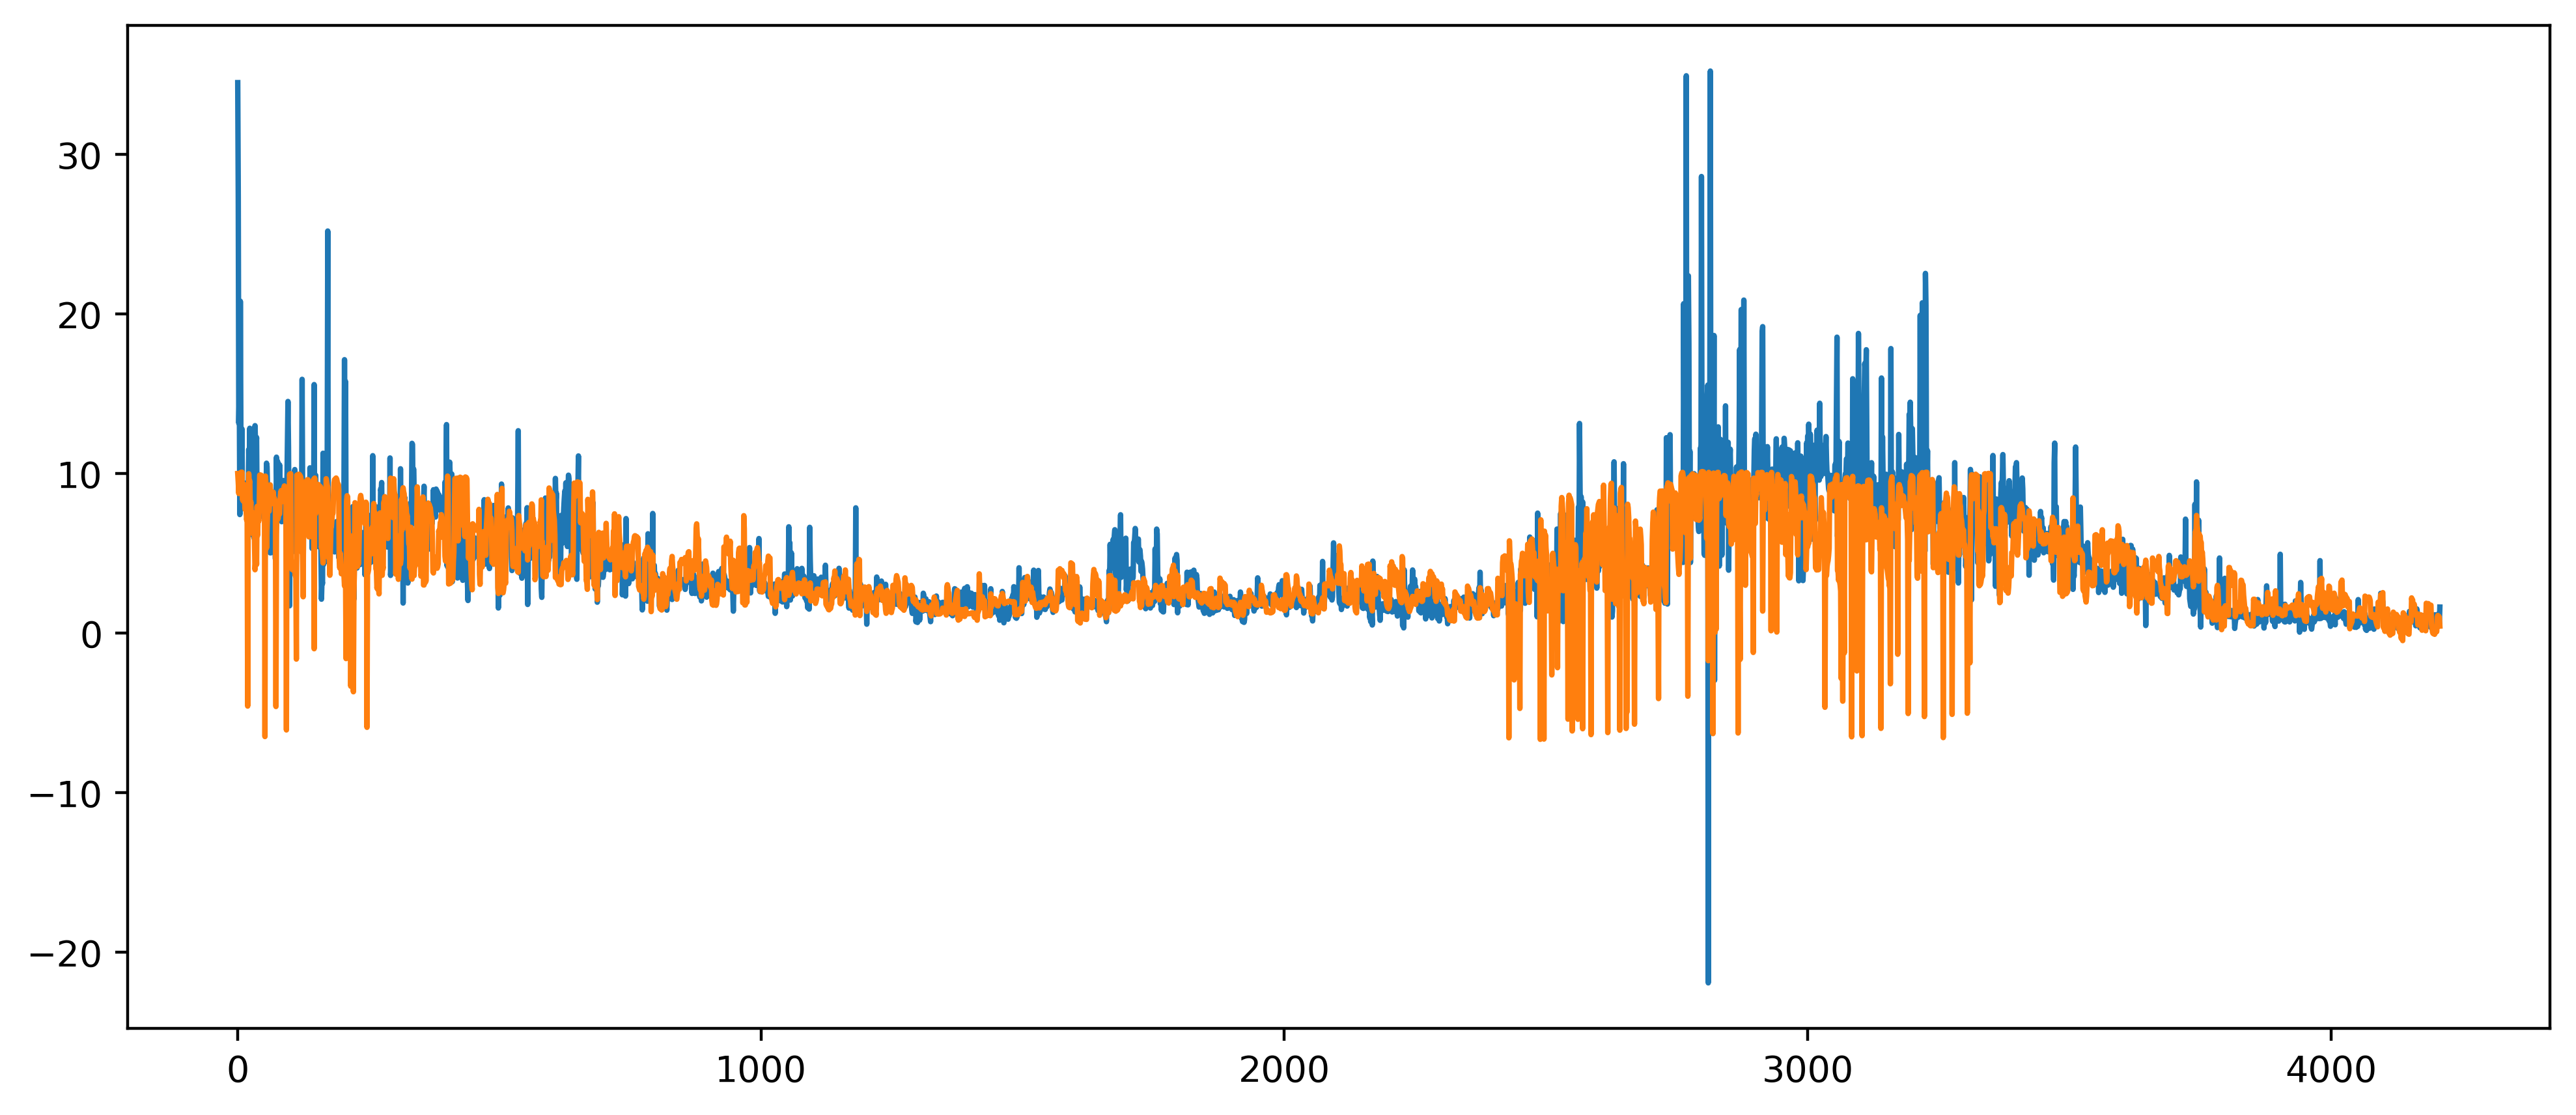

In [28]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
plt.plot(gt)
plt.plot(preds)

In [29]:
mean_absolute_error(gt, preds), r2_score(gt, preds)


(1.6085201912663787, 0.36655739994253744)

In [30]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(X_train, NEE_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [31]:
preds = rfr.predict(X_test)
gt = NEE_test

In [32]:
mean_absolute_error(gt, preds), r2_score(gt, preds)


(1.1811439078641008, 0.645008537160097)

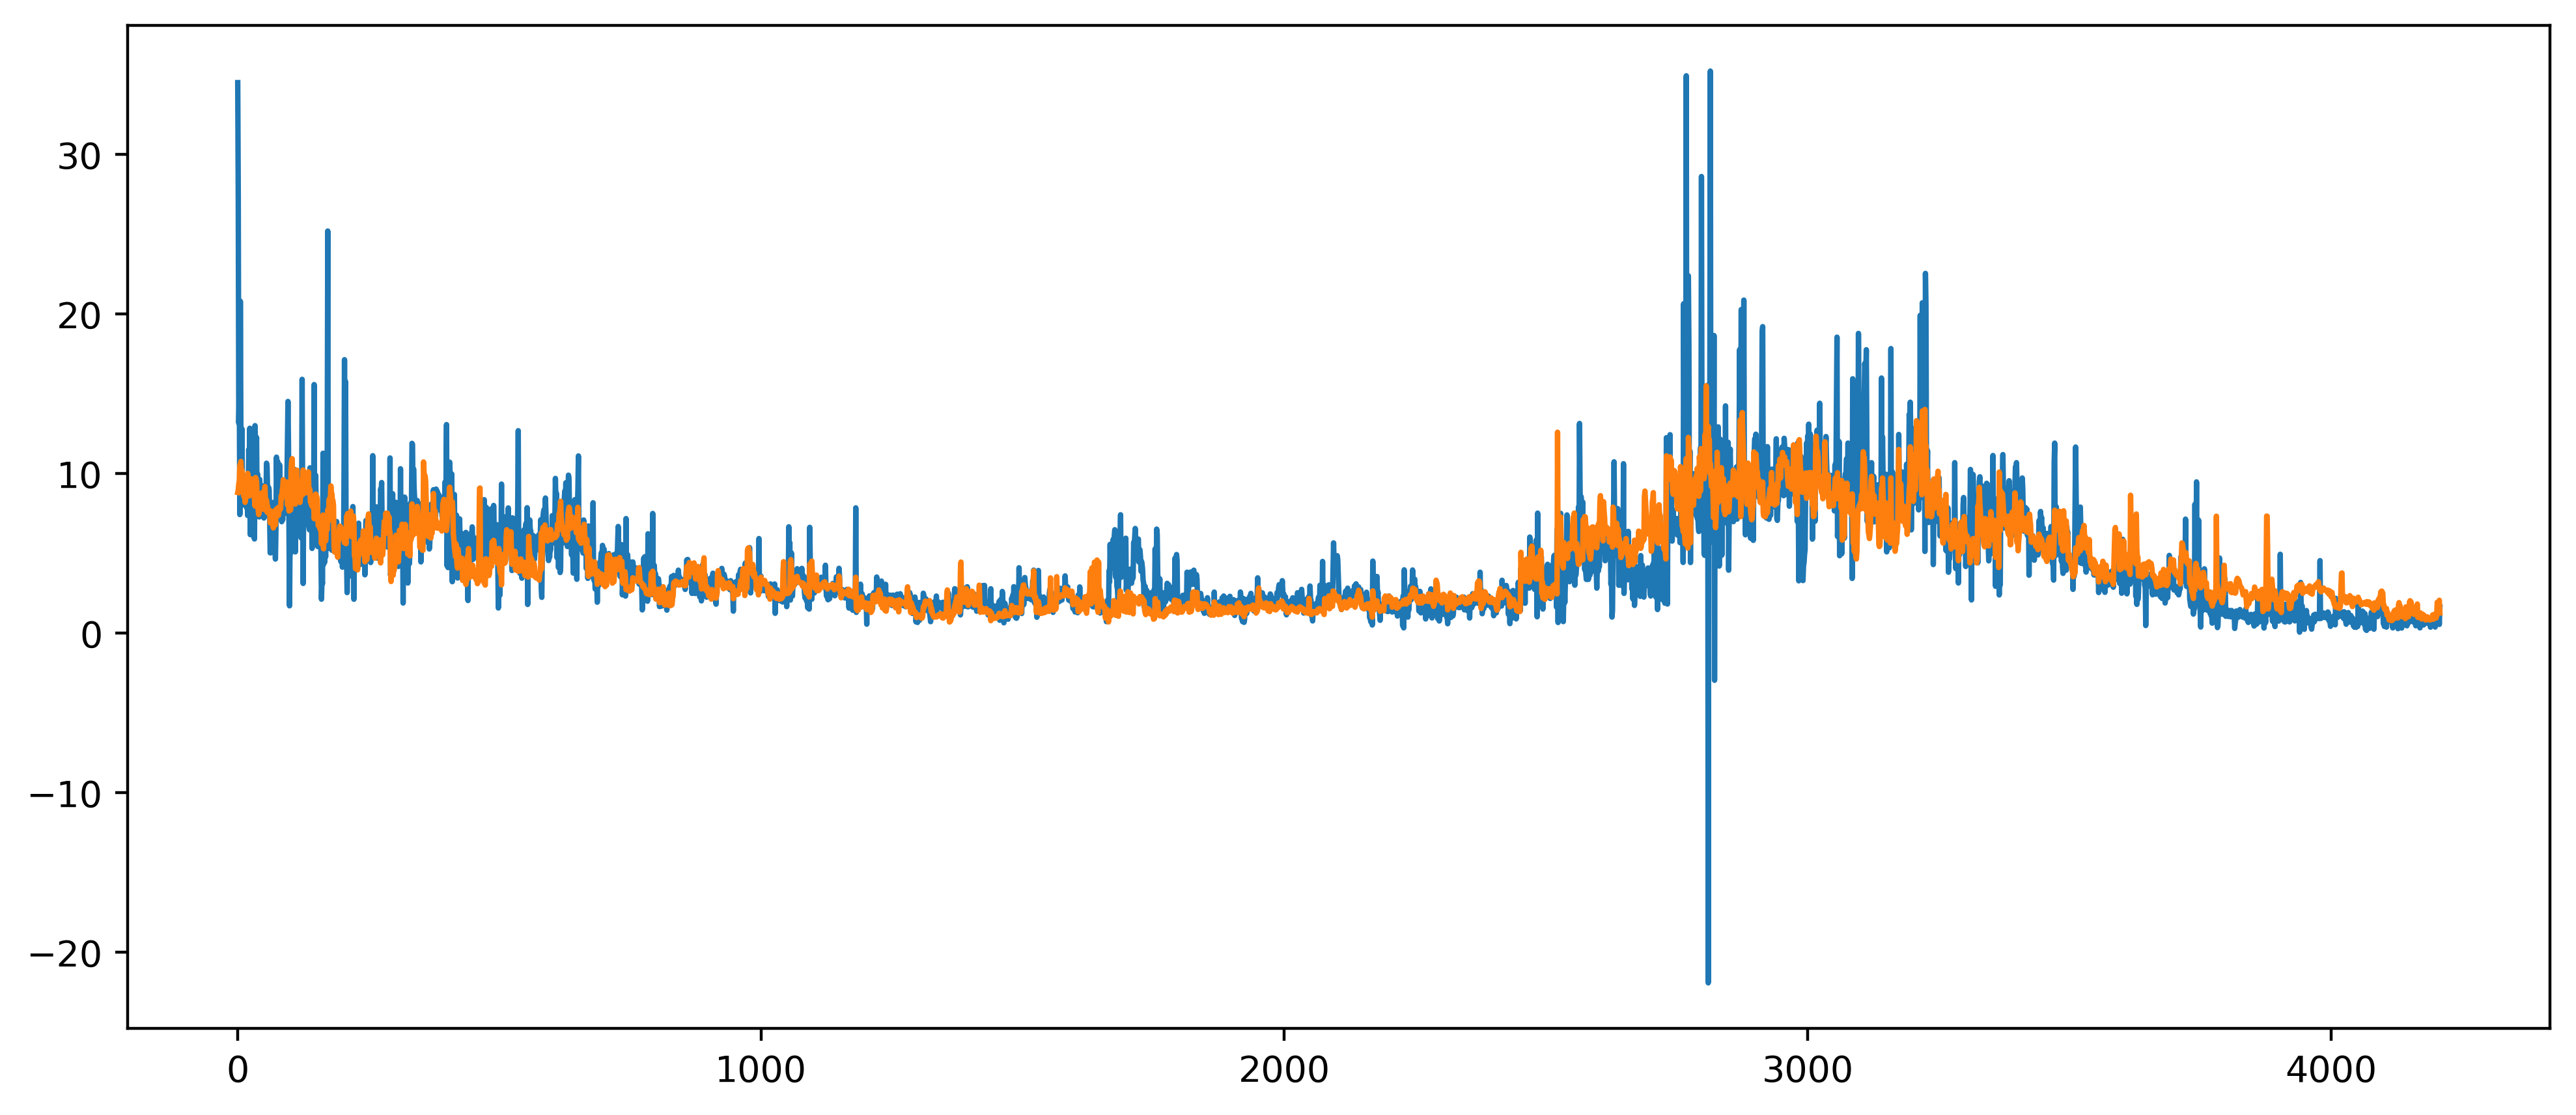

In [33]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
plt.plot(gt)
plt.plot(preds)